In [23]:
import json
import numpy as np
import math
import random

In [24]:
def parse(a):
    time = np.array(a['data'][0:4757])
    flux = np.array(a['data'][4757:])
    ids = a['id']
    return (time, flux, ids)

In [25]:
lc = sc.textFile("s3n://stat-37601/lightcurves.json").map(
                  lambda x: parse(json.loads(x)))

In [26]:
test = lc.first()
print test[0]

[ 1274.13960735  1274.16004181  1274.18047618 ...,  1371.28101622
  1371.30144916  1371.321882  ]


In [27]:
seed = random.randint(0,10000)
small_lc = lc.sample(False, 0.2, seed).cache()
print small_lc.count()
test = small_lc.first()
print test[1]

33995
[           nan  68464.6328125  69099.34375   ...,  71317.5390625
  71721.28125    71773.7421875]


In [48]:
gap = 0.0204
N = 4757
sz = (N-1)/2
u = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)
# tricube
def kernel_tricube(u):
    b = math.sqrt(2*math.pi)
    w = np.zeros(len(u))
    for i in range(len(u)):
        w[i] = (abs(u[i]) <= 1) * (1.0 - math.pow(abs(u[i]),3))
    return w[w>0]

def fit(x, h):
    w = kernel_tricube(u/h)
    flux = x[1]
    const = np.convolve(w, np.ones(len(flux), dtype=np.float64), 'same')
    yhat = np.convolve(w, np.nan_to_num(flux), 'same') / const
    return (np.nan_to_num(x[1]), yhat) # I added nan_to_num for x[1]

kernel_tricube([0,0,1,0.5])

array([ 1.   ,  1.   ,  0.875])

In [49]:
# bandwidth a.k.a. h = 1.0
fitted_small_lc = small_lc.map(lambda x: fit(x, 1.0))
#fitted_small_lc.take(5)

Implement cross-validation to find optimal h

In [50]:
candidates = [0.1, 0.3, 1.0]
# Get risk for given h, using equation from lecture
def get_risk(y, yhat, h):
    w = kernel_tricube(u/h)
    const = np.convolve(w, np.ones(len(y), dtype=np.float64), 'same')
    L = np.divide(1,const) # divide by the sum across all points except current one? const-w?
    risk = np.sum(np.divide(y-yhat, 1-L)**2)
    #print np.sum(y-yhat)
    return risk/len(L)

def get_h(x):
    risks = np.empty(0)
    for h in candidates:
        fitted = fit(x,h)
        risk = get_risk(fitted[0],fitted[1],h)
        #print (h, risk)
        risks = np.append(risks,risk)
        
    min_risk = risks.min()
    min_h = candidates[risks.argmin()]
    return min_h

get_h(test)

0.1

In [51]:
lc_h = small_lc.map(lambda x: (x, get_h(x))) #data with each respective optimal h

Part (b)-(d) Compute the residuals, standardize, and threshold.

In [54]:
def get_residuals(x, h):
    y, yhat = fit(x, h)
    resids = y-yhat
    
    #standardize
    MAD = np.median(np.abs(resids - np.median(resids)))
    sd = 1.4826*MAD
    resids = np.divide(resids - sum(resids)/len(resids), sd)
    
    #threshold
    beta = -1*math.sqrt(2*math.log(len(resids)))
    resids[resids>beta] = 0
    return resids

resids = lc_h.map(lambda x: (get_residuals(x[0],x[1]),x[0][2]))
#resids.cache()
print resids.first()[0]

[-65.52307652   0.           0.         ...,   0.           0.           0.        ]


Part (e) Compute L1 norm

In [55]:
def L1_norm(resids):
    return np.sum(np.abs(resids))

# Count number of residuals exceeding threshold and rank
def count_dips(resids):
    return np.count_nonzero(resids)

In [56]:
resids_norm = resids.map(lambda x: (L1_norm(x[0]),(count_dips(x[0]),x[1])))
resids_norm.first()

(4126.1215693370532, (73, u'kplr000757099-2012277125453_llc'))

Rank stars by norm

In [57]:
# Rank stars by norm
resids_norm = resids_norm.sortByKey()
rank_mag = resids_norm.map(lambda x: x[1])

In [58]:
# Rank norm
rank_array = rank_mag.take(2100)
print rank_array # Print star IDS with number of dips per star

[(0, u'kplr010802917-2012277125453_llc'), (0, u'kplr010975348-2012277125453_llc'), (26, u'kplr005881838-2012277125453_llc'), (40, u'kplr011341950-2012277125453_llc'), (43, u'kplr004241946-2012277125453_llc'), (49, u'kplr005786545-2012277125453_llc'), (49, u'kplr005961327-2012277125453_llc'), (48, u'kplr011442348-2012277125453_llc'), (49, u'kplr011405559-2012277125453_llc'), (49, u'kplr011566174-2012277125453_llc'), (48, u'kplr010854621-2012277125453_llc'), (49, u'kplr009388303-2012277125453_llc'), (49, u'kplr006118779-2012277125453_llc'), (49, u'kplr007130044-2012277125453_llc'), (49, u'kplr005791886-2012277125453_llc'), (49, u'kplr002437038-2012277125453_llc'), (49, u'kplr006106771-2012277125453_llc'), (47, u'kplr012458133-2012277125453_llc'), (49, u'kplr005535061-2012277125453_llc'), (49, u'kplr011498689-2012277125453_llc'), (50, u'kplr009594654-2012277125453_llc'), (49, u'kplr008690104-2012277125453_llc'), (49, u'kplr004859432-2012277125453_llc'), (51, u'kplr007432479-2012277125453_

Part 2. Detecting Planets

Methodology: We ranked the stars by norm, using the results from Part 1. We take the first 2100 stars, count how many dips each star had, then rerank the first 2100 stars by the number of dips. Ideally, we would be able to aggregate the rank by norm and by number of dips for all stars, but it took long to collect all stars. Since planets are smaller and eclipsing binary stars are expected to have shorter periods, this would suggest that stars with a high norm and a high number of dips are eclipsing binary stars. We also visually inspect the number of dips per star in a scatter plot.

In [68]:
rank_array = sorted(rank_array, reverse=True) # star IDs sorted by number of dips

Plots for the candidate stars (first 2100 stars by rank).

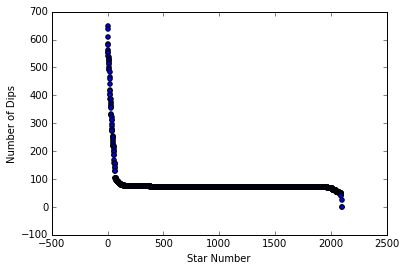

In [73]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# Plot number of dips (y-axis) against star number (x-axis).
x = np.arange(2100)
rank_dips = [t[0] for t in rank_array]

plt.scatter(x, rank_dips)
plt.xlabel("Star Number")
plt.ylabel("Number of Dips")
plt.show()

In [74]:
rank_both = [t[1] for t in rank_array]
rank_conf = rank_both[2000:]

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib2

def prcurve(ranking, positives, curvetitle):
    """
    Display the precision-recall curve and 
    compute the area under it. (See `prcurve_1` and `prcurve_2`.)
    """

    # Change ID formats
    mapping = pickle.load(urllib2.urlopen("https://s3.amazonaws.com/ml-lightcurves-q14/mapp.pickle"))
    as_dict = dict([(y, x) for (x, y) in mapping])
    ranking = [as_dict.get(x, None) for x in ranking]
    as_dict = None
    mapping = None

    # Precision-recall
    precision = []
    recall = []
    count = 0.0
    N = len(positives)
    for i, ID in enumerate(ranking):
        if ID in positives:
            count += 1.0
            precision.append( count/(i+1) )
            recall.append( count/ N )
        if count == N:
            break

    a = np.array(precision, dtype=np.float32)
    area = np.sum(a / N)

    plt.plot(recall, precision, '-r', linewidth=2)
    plt.xlabel('recall', fontsize=15)
    plt.ylabel('precision',fontsize=15)
    plt.xlim((-0.01,1.01))
    plt.title('{} area = {}'.format(curvetitle, area), fontsize=15)
    plt.show()

    return area

def prcurve_1(ranking):
    """
    PART I: detect confirmed or eclipsing binary stars
    """
    conf_and_eb_id = [int(i) for i in 
                      urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_eb_id.txt')]
    conf_cand_eb_id = [int(i) for i in
                       urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_cand_eb_id.txt')]
    
    return (prcurve(ranking, conf_and_eb_id, "conf+eb"),
            prcurve(ranking, conf_cand_eb_id, "conf&cand+eb"))

def prcurve_2(ranking):
    """
    PART II: detect confirmed stars
    """
    conf_id = [int(i) for i in 
               urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_id.txt')]
    conf_and_cand_id = [int(i) for i in 
                        urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_cand_id.txt')]
    
    return (prcurve(ranking, conf_id, "conf"),
            prcurve(ranking, conf_and_cand_id, "conf&cand"))

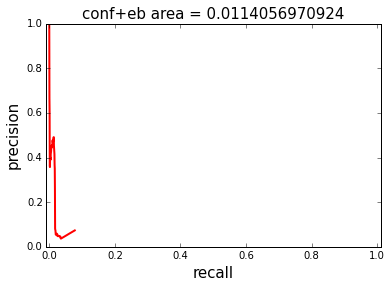

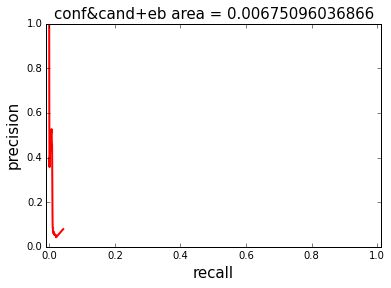

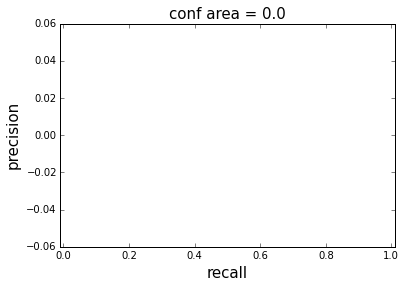

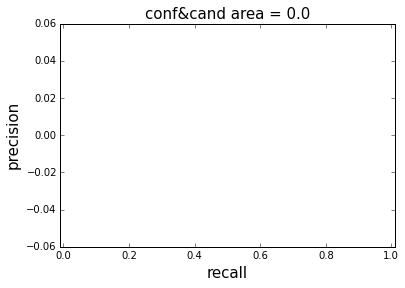

(0.0, 0.0)

In [76]:
prcurve_1(rank_both)
prcurve_2(rank_conf)